# Basic Network Analysis and Visualizations - Deep Learning and Neural Networks with Python and Pytorch p.8


Welcome to part 8 of the deep learning with Pytorch series. In this tutorial, we'll be covering how to do analysis of our model, at least at a basic level, along with honing in more on our training loop and code.

One of the main questions that we have at the moment is: How many epochs should we do? When will we know when to stop training?

We've determined that this model does learn, but also, how might we determine if some other model that we think of is better or worse?

With larger datasets and models that can take days/weeks/months to train, we want to know how to evaluate them in shorter periods of time to determine if we should keep training.

To begin, we'll, at the very least, want to start calculating accuracy, and loss, at the epoch (or even more granular) level.

Not only this, but we'll want to calculate two accuracies:

In-sample accuracy: This is the accuracy on the data we're actually feeding through the model for training. This is the data that we're "fitting" against.

Out-of-sample accuracy: This is the accuracy on data that we've set aside that the model will never see/fit against.

In general, we expect in-sample accuracy to be higher than out-of-sample accuracy. You may also hear "out of sample" accuracy referred to as "validation accuracy." While we expect validation/out-of-sample accuracy to be a bit worse than the in-sample accuracy, we want to track that delta. Something like 5-10% accuracy difference is pretty common, but as this delta grows, it usually signals to us that our model is beginning to "overfit" (the neural network is just memorizing the data and changing weights to work only for the training data, rather than generally understanding the data).

You can also track in and out of sample loss. You will often be able to spot both losses decline to a point, and then out of sample loss begins to arc and curve back upwards. This is usually a sign that you've gotten the most out of your model's training.

We can see this in practice with our current dataset most likely, so let's start to work on our code to handle for this. Our code up to this point is:

In [13]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!sudo apt-get install unzip
!unzip kagglecatsanddogs_3367a.zip
!pip3 install jupyterlab

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5584.jpg  
  inflating: PetImages/Dog/5585.jpg  
  inflating: PetImages/Dog/5586.jpg  
  inflating: PetImages/Dog/5587.jpg  
  inflating: PetImages/Dog/5588.jpg  
  inflating: PetImages/Dog/5589.jpg  
  inflating: PetImages/Dog/559.jpg   
  inflating: PetImages/Dog/5590.jpg  
  inflating: PetImages/Dog/5591.jpg  
  inflating: PetImages/Dog/5592.jpg  
  inflating: PetImages/Dog/5593.jpg  
  inflating: PetImages/Dog/5594.jpg  
  inflating: PetImages/Dog/5595.jpg  
  inflating: PetImages/Dog/5596.jpg  
  inflating: PetImages/Dog/5597.jpg  
  inflating: PetImages/Dog/5598.jpg  
  inflating: PetImages/Dog/5599.jpg  
  inflating: PetImages/Dog/56.jpg    
  inflating: PetImages/Dog/560.jpg   
  inflating: PetImages/Dog/5600.jpg  
  inflating: PetImages/Dog/5601.jpg  
  inflating: PetImages/Dog/5602.jpg  
  inflating: PetImages/Dog/5603.jpg  
 extracting: PetImages/Dog/5604.jpg  
  inflating: PetImages/Dog/5605.jpg  

In [16]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)



if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 808.51it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 763.86it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470
Running on the CPU


In [17]:
net = Net().to(device)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1, 1, 50, 50).to(device))[0]

            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy:", round(correct/total,3))

PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 828.52it/s]


PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 775.36it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470
49892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


4989
44903
4989


With the above code, we can train and then test our network, but not quite to the degree that we want. Let's start by modifying our train function:

In [18]:
net = net.to(device)

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            net.zero_grad()
            outputs = net(batch_X)

            matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
            in_sample_acc = matches.count(True)/len(matches)

            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(loss)
        print("In-sample acc:",round(in_sample_acc, 2))

train(net)

100%|██████████| 450/450 [03:20<00:00,  2.24it/s]


tensor(0.1634, grad_fn=<MseLossBackward0>)
In-sample acc: 0.67


100%|██████████| 450/450 [03:21<00:00,  2.23it/s]


tensor(0.2388, grad_fn=<MseLossBackward0>)
In-sample acc: 0.67


100%|██████████| 450/450 [03:20<00:00,  2.24it/s]

tensor(0.0691, grad_fn=<MseLossBackward0>)
In-sample acc: 1.0


Since we already know the targeted values and the actual ones, all we need to do is compare them, and do some sort of % accuracy on the output. To do this, we just compared the argmaxes of both and count the Trues to determine accuracy.

So this is our "in sample" accuracy. We are also calculating our "in sample" loss here that we can also be taking note of.

Aside from calculating the in-sample accuracy every epoch, we would like to see some testing data every epoch.

Some datasets might be so large that we'd like to see data every step or every 1K steps... etc (where epochs might be days or longer).

Because Pytorch gives us fairly low-level access to how we want things to work, how we decide to do things is entirely up to us. If you want your models to run faster, then you should do things like validation tests less frequently, or on lower amounts of data. For example, our validation data has 2500 samples or so. That means we need our model to take 25 steps at a batch size of 100.

If we did this every step, we'd be effectively slowing our entire neural network by 26x (taking 25 extra steps per 1 step). Thus, if we intend to do validation testing every step, we should probably do this with a smaller snippet of our testing data.

From here, it could be tempting to write a new function, like:

In [19]:
def batch_test(net):
    BATCH_SIZE = 100
    correct = 0
    total = 0
    with torch.no_grad():
        #np.random.shuffle(test_X)
        #np.random.shuffle(test_y)

        batch_X = test_X[:BATCH_SIZE].view(-1,1,50,50)
        batch_y = test_y[:BATCH_SIZE]

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        net.zero_grad()
        outputs = net(batch_X)

        matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, batch_y)]
        acc = matches.count(True)/len(matches)

        print("Test Accuracy:", round(acc, 3))


batch_test(net)

Test Accuracy: 0.76


At least that's what I did initially, so I am sharing it here.

Another stupid thing I did was, within that function, what I commented out with the shuffling of our x and y data. I wanted to shuffle the data because I wanted to slice out a random BATCH_SIZE of the validation data for the testing by shuffling and then grabbing the first 100.

I went through with that, but was baffled for a short time when my validation accuracy was consistently ~50%...then I realized I was shuffling those two things separately.

The real solution would be to zip these two together, then shuffle, then slice the first BATCH_SIZE.

Once I found myself at that line of thinking, I then began to be bothered by the repetition. Our testing, training, and now a new function that did some batch size of testing was all using very similar code...and dangit, we gotta do this better. This code is quickly bloating.

This is where Pytorch can become a challenge for newbies (like me apparently). This is where you begin to make all sorts of silly mistakes and forgetting obvious things that you knew, but just forgot to do.

... or where you begin to introduce lots of technical debt into your code :)

Okay, so let's try to do better. I tend to write messy code as it is, so cut me some slack, but I can at least fix all this repetition.

I am tempted to call this function fit, but what this function will do is do a forward pass, it wont always be a fitment where we adjust weights. We already have a forward method, so I don't think we want to conflict with that. We also can't really take away the pass statement... so what the heck do we call this?

I'll just call this fwd_pass for now:

In [20]:
def fwd_pass(X, y, train=False):

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss

Either way, we want to still calc gradients, so that we can still compute the loss. Later, we can have a function that purely predicts, and that will do the whole with torch.no_grad thing. The only thing we want to check for is to see if this is meant to be training the model or not. We definitely do not want to modify weights when we do our validation data, for example. For this reason, I am going to default this to be False. I'd rather forget and not train the model at all (which will become quite obvious to us fairly fast) than to forget this flag and have our validation data secretly training the model, which would be much harder to notice.

So let's test this out:

In [21]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            acc, loss = fwd_pass(batch_X, batch_y, train=True)

            print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")

            # just to show the above working, and then get out:
            if i == 5:
                break
            break

train(net)

  0%|          | 0/450 [00:00<?, ?it/s]


Acc: 0.48  Loss: 0.2503


  0%|          | 0/450 [00:00<?, ?it/s]


Acc: 0.52  Loss: 0.2497


  0%|          | 0/450 [00:00<?, ?it/s]

Acc: 0.48  Loss: 0.2509


So far so good! ... but printing this all out every step is going to get a bit absurd.

Instead, let's just save it to some log file. Now we're getting close, but still quite a distance, from Tensorflow's Tensorboard, which is what Tensorflow uses to log the stats of your model.

You also can use something called tensorboardx with Pytorch, which should allow you to make use of Tensorboard with your Pytorch models.

That said, I am having a hard time seeing why we'd do that.

I've been doing deep learning with Tensorflow since about when Tensorflow was first released, and, when I consider the things that I've actually done with Tensorboard, 99% of it has been tracking some basic scalar values.

While tensorboard is neat, sure, it's often kind of annoying, it can present a lot of overhead, and need a decent amount of work to get it showing what you want. In short, if it's already there, okay whatever, I'll use it.

...but I am not going to go out of my way to incorporate Tensorboard into Pytorch. We really do not need it, and after spending time making things just the way we want, we're probably spending more time with Tensorboard code than we would have if we just coded what we wanted and were in full control.

To start, I am just going to use Matplotlib. Later you could get fancy and use something like Dash, or even just Pygal, or something else entirely. Heck, if you want, check out tensorboardx! That's the fun thing about Pytorch. It's Pythonic and open. You can do whatever you want. No one is forcing you into anything! I am showing you one of many ways for you to do a thing.

So now our train function could instead be something like:

In [22]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 

net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                f.write(f"{MODEL_NAME},{int(time.time())},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i == 5:
                    break
                break

train(net)

  0%|          | 0/450 [00:00<?, ?it/s]


That looks to me like it's working. We could make these logs super fancy over time, and maybe later use something more like sqlite or something to log various models and such. For now, this is more than enough. In fact, it really is more logging than we need, since we can see that actually we're logging intra-second. We could fix this by allowing the full time, or at least out to some decimals.

In [23]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                f.write(f"{MODEL_NAME},{round(time.time(),3)},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i == 5:
                    break
                break

train(net)

  0%|          | 0/450 [00:00<?, ?it/s]


The only change here is f.write(f"{MODEL_NAME},{round(time.time(),3)},in_sample,{round(float(acc),2)},{round(float(loss),4)}\n"), where we're just grabbing some of the decimals from the time.time() too. Now we could graph with:

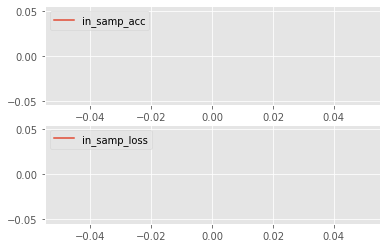

In [24]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1570490221" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, sample_type, acc, loss = c.split(",")

            times.append(timestamp)
            accuracies.append(acc)
            losses.append(loss)


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="in_samp_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="in_samp_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

Okay, not bad. We can improve a lot here, but, for now, we just want to see certain things, and see that it's entirely up to us what we want to track and how.

Next, we want to track out of sample accuracy and loss. Again, we can track this out of sample information as much or as little as we want in a variety of ways. How often do we want to calculate this? On how much data? It's all up to us (you!).

At 225 steps, we could validate every step, but this would increase training time significantly. We're not doing backprop, but still computing loss and such. How granular of data we really want is, again, up to you, I'm going to go with say a random BATCH_SIZE of the validation data every 10 steps, and then we could do the entirety of the validation data at the very end. So we could make a validation function like:

In [25]:
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.55 tensor(0.2493, grad_fn=<MseLossBackward0>)


In [27]:
# Okay so now, every 10 steps, let's run this test function. We can also just combine the logging to the same time/row too:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 10 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)}\n")
train(net)

100%|██████████| 450/450 [04:31<00:00,  1.66it/s]


As you can see, our epoch times have gone from ~14 seconds to 25 seconds. We've probably got quite a few things that we could be optimizing. Having full control over this sort of thing is both a gift and a curse. You have the opportunity to do things exactly how you want, and possibly faster. ...but you can also really slow yourself down a lot if you're not careful. We can talk more on optimizing our logging later. For now, let's check out what we've got. For me, my latest model name was model-1570499409.

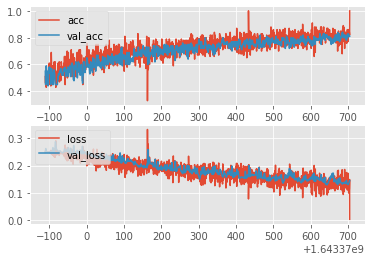

In [28]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [29]:
import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)
def train(net):
    BATCH_SIZE = 100
    EPOCHS = 30

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")
train(net)

model-1643371182


100%|██████████| 450/450 [04:38<00:00,  1.61it/s]


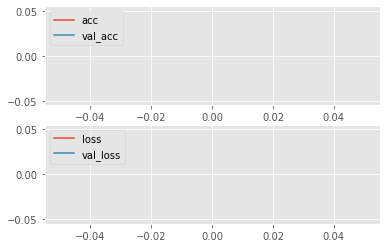

In [12]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = "model-1570499915" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

Alright so clearly it was more like 4-5 epochs (each epoch is ~25 seconds atm, and our X axis is time) before things started to go sour. So now we know, at least with our current model/settings, that somewhere between 4 and 5 epochs is all we want to train for. We can see how bad things already are getting by 8-10 epochs. Validation accuracy doesn't seem to suffer much, interestingly enough, but we'd still probably want to stop far before this.

Hopefully this has helped you to visualize neural networks learning, and the main stats that you want to track. Also, you can see just how well neural networks can generalize initially, but later overfit and just memorize the data later on. You can see that we're getting 100% accuracy on some of those batches, and, over time, that deviation from 100% accuracy is shrinking. If we keep training for more and more epochs, this model will eventually most likely reach a perfect 100% accuracy on in-sample data.

That's all for now. With this, you can graph really anything you want, you could continue to use Matplotlib (which has tons of fancy features like multi-y axis, and all sorts of other customizations. You can learn more here: Data Visualization w/ Matplotlib), or you can use any other charting program you want. Or look into tensorboardx. I just honestly don't see why we'd force ourselves to use Tensorboard here, given what I have personally used Tensorboard for and the custom work I've had to do to get tensorboard to show me what I do want.